### Assumptions Prior to Using This Module 

1. To use "balanced" data set, please run Analyzer to generate the dataset first (it may take about 30 mins)
   - Example input: <project_dir>/loinc_predictor/data/andromeda-pond-hepatitis-c-balanced.csv
   
2. To use regular data (the sampled dataset from Andromeda), there's nothing you need to do.
   - Example input: <project_dir>/loinc_predictor/data/andromeda-pond-hepatitis-c.csv
   

In [1]:
import pandas as pd 
from pandas import DataFrame, Series
import os, sys, re
import numpy as np
from decimal import Decimal
from utils_sys import highlight

import warnings
warnings.filterwarnings('ignore')  # action='once'

# local modules
from analyzer import load_data, save_data, load_performance
import loinc as lc

%matplotlib inline

### Determine Target Cohort

In [2]:
cohort = 'hepatitis-c'

### Define Feature Set

In [3]:
"""
Memo
----
1. medivo_test_result_type is a function of the following attributes: 
      "meta_sender_name",
      "receiving_organization_id",
      "test_order_code",
      "test_order_name",
      "test_result_code",
      "test_result_name",
      "test_result_loinc_code",
      "test_result_units_of_measure"
      
"""
from analyzer import sample_col_values
from loinc import FeatureSet

cat_cols = FeatureSet.cat_cols  # 22 vars
cont_cols = FeatureSet.cont_cols  # e.g. age
derived_cols = FeatureSet.derived_cols
# ... ['count']  # other possible vars: test result n-th percentile, normalized test frequency

target_cols = FeatureSet.target_cols  # ['test_result_loinc_code', ]

# cardinality < 100
low_card_cols = FeatureSet.low_card_cols # ['patient_gender', 'fasting', 'meta_sender_name' ]
high_card_cols = FeatureSet.high_card_cols

target_columns = cat_cols + cont_cols + target_cols

### Load (Curated) Training Data

note: Training data was saved prior to the variable encoding

In [4]:
from analyzer import load_src_data, analyze_values

# input_file = f"andromeda-pond-{cohort}.csv" # or f"andromeda-pond-{cohort}-balanced.csv"
# ts = load_data(input_file=input_file, warn_bad_lines=False)
ts = load_src_data(cohort=cohort, warn_bad_lines=False, canonicalized=True, processed=True)

print("(load) dim(df): {} | columns:\n{}\n".format(ts.shape, 
        list(ts.columns.values[:10])+['...']+list(ts.columns.values[-10:]))) 
# ... 'ts' at this point contains all variables

# check feature values
analyze_values(ts, cols=cat_cols, topn=10)  # topn: most common n feature values (and their counts)

[load] Loading default input data: andromeda-pond-hepatitis-c-processed.csv
(canonicalize) Operations: fill n/a + dehyphenate + replace_values + trim_tail + fill others (non-target classes)
(load) dim(df): (71224, 127) | columns:
['meta_package_key', 'input_filename', 'patient_date_of_birth', 'patient_gender', 'patient_state', 'patient_bill_type', 'diagnosis_codes', 'diagnosis_descriptions', 'laboratory_diagnosis', 'billing_diagnosis_codes', '...', 'meta_dict_orig', 'meta_dict_final', 'meta_ingestion_datetime', 'meta_original_filename', 'meta_sender_name', 'meta_sender_source', 'meta_sender_type', 'meta_sender_dataset', 'meta_sender_ver', 'medivo_test_result_type']

[1] name: patient_gender => values: 
[('M', 42620), ('F', 28555), (nan, 49)]
 ... mode: M
[2] name: patient_state => values: 
[('CA', 9616), ('TX', 8828), ('FL', 7549), ('NY', 5827), ('PA', 4453), ('NJ', 3864), ('MD', 3269), ('GA', 1902), ('NC', 1675), ('TN', 1556)]
 ... mode: CA
[3] name: patient_bill_type => values: 
[('P

{'patient_gender': [('M', 42620), ('F', 28555), (nan, 49)],
 'patient_state': [('CA', 9616),
  ('TX', 8828),
  ('FL', 7549),
  ('NY', 5827),
  ('PA', 4453),
  ('NJ', 3864),
  ('MD', 3269),
  ('GA', 1902),
  ('NC', 1675),
  ('TN', 1556)],
 'patient_bill_type': [('PI', 18695),
  ('PRIVATE INSURANCE', 14270),
  ('CM', 10032),
  (nan, 8672),
  ('MC', 5098),
  ('MEDICARE', 4390),
  ('MEDICAID', 2668),
  ('MD', 2549),
  ('MANAGE CARE FFS', 2436),
  ('CLIENT', 1161)],
 'fasting': [(nan, 61446),
  ('NOT FASTING', 3942),
  ('Y', 1986),
  ('N', 1334),
  ('U', 1269),
  ('FASTING', 1247)],
 'performing_organization_id': [(nan, 29269),
  ('BN', 13666),
  ('RN', 5484),
  ('CPLSW', 4374),
  ('SO', 2292),
  ('CB', 2118),
  ('TA', 1973),
  ('MB', 1743),
  ('DA', 1267),
  ('PDLCA', 1227)],
 'receiving_organization_id': [(nan, 37380),
  ('CPLSW', 4374),
  ('22', 3660),
  ('28', 3054),
  ('17', 3024),
  ('1', 2727),
  ('15', 2360),
  ('35', 1579),
  ('30', 1529),
  ('41', 1370)],
 'test_result_status': [(

### Feature Transformation
note: patient_date_of_birth => age

In [5]:
from transformer import to_age
from analyzer import col_values
from loinc import FeatureSet

tTransformed = False

FeatureSet.to_age(ts)
values = col_values(ts, col='age', n=10)
print("> age: {}".format(values))

# datatime columns

> age: [71 61 69 72 59 71 69 68 62 69]


### Subset Variables, Encode Variables and Handling Missing Values

In [6]:
from analyzer import feature_transform

regular_vars, target_vars, derived_vars, meta_vars = FeatureSet.categorize_features(ts)
highlight("Found {} reg vars | {} label vars".format(len(regular_vars), len(target_vars)))
msg = ""
msg += "... regular_vars:  {}\n".format(regular_vars)
msg += "... target vars:   {}\n".format(target_vars)
msg += "... derived vars:  {}\n".format(derived_vars)
msg += "... meta_vars:     {}\n".format(meta_vars)
print(msg)

ts = feature_transform(ts, drop_high_missing=False, pth_null=0.9, verbose=1)

Found 23 reg vars | 1 label vars
... regular_vars:  ['patient_gender', 'patient_state', 'patient_bill_type', 'fasting', 'performing_organization_id', 'receiving_organization_id', 'test_result_status', 'test_order_code', 'test_order_name', 'test_result_code', 'test_result_name', 'test_result_value', 'test_result_range', 'test_result_abnormal_flag', 'test_result_reference_range', 'test_result_units_of_measure', 'test_result_comments', 'test_cpt_code', 'panel_order_code', 'panel_order_name', 'meta_sender_name', 'medivo_test_result_type', 'age']
... target vars:   ['test_result_loinc_code']
... derived vars:  []
... meta_vars:     []

[transform] age: [71 61 69 72 59 71 69 68 62 69]
(encoder_vars2) low card vars (n=['meta_sender_name', 'patient_gender', 'fasting']):
3
 ... high card vars (n=['test_result_units_of_measure', 'test_result_range', 'test_order_name', 'panel_order_name', 'patient_state', 'performing_organization_id', 'test_result_reference_range', 'test_order_code', 'test_result

### Partition Variables

In [7]:
from analyzer import encode_labels, summarize_dict, get_sample_sizes
import collections, operator

codebook={'pos': 1, 'neg': 0, '+': 1, '-': 0}

tsX, tsY, ts_derived, ts_meta = FeatureSet.partition(ts)

print("> Found n(X)={}, n(Y)={}, n(Derived)={}, n(Meta):{}".format(
    tsX.shape[1], tsY.shape[1], ts_derived.shape[1], ts_meta.shape[1]))

# verify
assert tsX.shape[0] == tsY.shape[0]

[partition] 203 reg vars | 1 label vars
... regular_vars (X): ['patient_gender_1', 'patient_gender_2', 'patient_gender_3', 'patient_state_0', 'patient_state_1', 'patient_state_2', 'patient_state_3', 'patient_state_4', 'patient_state_5', 'patient_state_6', 'patient_bill_type_0', 'patient_bill_type_1', 'patient_bill_type_2', 'patient_bill_type_3', 'patient_bill_type_4', 'fasting_1', 'fasting_2', 'fasting_3', 'fasting_4', 'fasting_5', 'fasting_6', 'performing_organization_id_0', 'performing_organization_id_1', 'performing_organization_id_2', 'performing_organization_id_3', 'performing_organization_id_4', 'performing_organization_id_5', 'performing_organization_id_6', 'performing_organization_id_7', 'performing_organization_id_8', 'receiving_organization_id_0', 'receiving_organization_id_1', 'receiving_organization_id_2', 'receiving_organization_id_3', 'receiving_organization_id_4', 'receiving_organization_id_5', 'receiving_organization_id_6', 'test_result_status_0', 'test_result_status_1'

### Model Training

In [8]:
import utils_tree, utils_sys, analyzer
import collections
from analyzer import balance_by_downsampling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from loinc import TSet, FeatureSet, LoincTSet
from common import apply_scaling

def get_sample_size(y, code_book={}):
    if not code_book: code_book = TSet.codebook
    counter = collections.Counter(y)
    return (counter[codebook['neg']], counter[codebook['pos']])

# model training parameters 
n_fold = 5
n_min = n_fold  # min number of examples to train a classifier
scaling_method = 'minmax'
tBalance = True   # balance the data set? If True, will attempt to limit the sample size of the majority class

# data transformation
col_target = LoincTSet.col_target  # 'test_result_loinc_name'
# regular_vars, target_vars, derived_vars, meta_vars = FeatureSet.categorize_features(ts)

# subsampling parameters 
majority_max = 10    # majority class is only allowed to have at most this multiple of samples than the minority class
sampling_method = 'multiple'

X, y = tsX.values, tsY.values.flatten()
loinc_set = raw_labels = np.unique(y)
print("> dim(X): {}, sample(y): {}".format(X.shape, np.random.choice(loinc_set,20) ))

# feature scaling
X = apply_scaling(X, scaler=scaling_method)

# attributes for performance data
header = ['code', 'mean', 'std', 'n_pos', 'total']
sdict = {h:[] for h in header}
for code in loinc_set: 
    y_bin = analyzer.encode_labels(y, pos_label=code)
    
    n_neg0, n_pos0 = get_sample_size(y_bin)
    
    if n_pos0 >= n_min: # if n(pos) is above a min threshold, then train a model
        
        # we could have done subsampling here but then the else case wouldn't get a corret
        if tBalance: 
            X_eff, y_eff = balance_by_downsampling(X, y_bin, method=sampling_method, majority_max=majority_max)
            assert isinstance(y_eff, np.ndarray) and isinstance(X_eff, np.ndarray)
        else: 
            X_eff, y_eff = X, y_bin
        
        n_neg, n_pos = get_sample_size(y_eff)
        
        # training + evaluation (default classifier: logistic regression)
        scores = analyzer.eval_performance(X_eff, y_eff, model=None, cv=n_fold, random_state=53, verbose=1)
        # metric: f1 score
        
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print("... average Fmax: {}, std: {}".format(mean_score, std_score))
    else: 
        print("> (positive) sample size too small, n={}".format(n_pos0))
        mean_score = -1 
        std_score = -1
        
        # hypothetical sample sizes if one were to train this classifier
        n_neg = min(n_pos0, n_neg0) * majority_max
        n_pos = n_pos0
        
    print(f"... Code: {code} | sample size | n0(-): {n_neg0}, n0(+): {n_pos0} ->(subsample)-> n(-): {n_neg}, n(+): {n_pos}")
        
    sdict['code'].append(code)
    sdict['mean'].append(mean_score)
    sdict['std'].append(std_score)
    sdict['n_pos'].append(n_pos)
    sdict['total'].append(n_pos+n_neg)

# --------------------------------------------------
# save performance dataframe
df_perf = DataFrame(sdict, columns=header)
df_perf = df_perf.sort_values(by=['mean', ]) # ascending=False
analyzer.save_performance(df_perf, output_dir='result', cohort=cohort, verbose=1)  # other opts: output_file
# ... default sep: '|' but NOT ',' 


> dim(X): (71224, 203), sample(y): ['305227' '7377' '424838' '33498' '216960' '195933' '533265' '32896'
 '493114' '31385' '241240' '298927' '406611' '462168' '423327' '551598'
 '823781' '169490' '155465' '381772']
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 005025 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 10058 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 103317 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 103341 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71209,

> Fmax: 1.0 p_th: 0.9773302854074277 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.975888324610127 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9541458913609547 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 111567 | sample size | n0(-): 71219, n0(+): 5 ->(subsample)-> n(-): 50, n(+): 5
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 112532 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71050, 1: 174})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9693346633469652 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.3302183033441283 | F1: 0.9705882352941176, AUC: 1.0
> 2 of KFold 5
> Fmax: 0.9855072463768115 p_th: 0.895710876184601 | F1: 0.9714285714285714, AUC: 0.999671592775041
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.

> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9589604208935287 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 134577 | sample size | n0(-): 70601, n0(+): 623 ->(subsample)-> n(-): 6230, n(+): 623
(encode_labels) sample size: Counter({0: 70885, 1: 339})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 0.9855072463768115 p_th: 0.1497231067588964 | F1: 0.9850746268656716, AUC: 0.999913239632136
> 1 of KFold 5
> Fmax: 0.9925925925925926 p_th: 0.317986539207137 | F1: 0.9774436090225563, AUC: 0.9998698594482041
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9827497406267068 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.988733842441726 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9638019743688618 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9956199677938808, std: 0.0058135390503298535
... Code: 134585 | sample size | n0(-): 70885, n0(+): 339 ->(subsample)-> n(-): 3390, n(+): 339
(encode_

(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9859957026594709 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9582375349735116 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.97909165104211 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9790907895184988 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9943070546683684 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 142513 | sample size | n0(-): 71185, n0(+): 39 ->(subsample)-> n(-): 390, n(+): 39
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 142729 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 142778 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) samp

... Code: 154328 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 155465 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71219, 1: 5})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9536578967901792 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8190615513345876 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8585973614178273 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9554423080123992 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.7109289568952073 | F1: 0.6666666666666666, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 15586 | sample size | n0(-): 71219, n0(+): 5 ->(subsample)-> n(-): 50, n(+): 5
(encode_labels) sample size: Counter({0: 71223,

> Fmax: 0.9979166666666666 p_th: 0.9813307704150972 | F1: 0.9979166666666666, AUC: 0.9999965422002846
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.8368323397145706 | F1: 0.9979253112033196, AUC: 1.0
... average Fmax: 0.998545770810203, std: 0.0010575619044179484
... Code: 17426 | sample size | n0(-): 68819, n0(+): 2405 ->(subsample)-> n(-): 24050, n(+): 2405
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 174334 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 70945, 1: 279})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.97901865787056 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 0.9818181818181818 p_th: 0.9891788839697648 | F1: 0.9818181818181818, AUC: 0.9984318996415771
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9894016530292389 | F1: 0.9911504424778761, AUC: 1.0
> 3 of

(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9825281747811871 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.986071380556767 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9849886155983588 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9826831511828298 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9774746487287503 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 181826 | sample size | n0(-): 71218, n0(+): 6 ->(subsample)-> n(-): 60, n(+): 6
(encode_labels) sample size: Counter({0: 71185, 1: 39})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.26175117418461963 | F1: 0.9333333333333333, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9873353137302474 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.98669339248056

> 4 of KFold 5
> Fmax: 0.9987293519695045 p_th: 0.9404218751175497 | F1: 0.9974619289340102, AUC: 0.9999974245854226
... average Fmax: 0.9994923849693128, std: 0.000621699739821311
... Code: 19208 | sample size | n0(-): 69253, n0(+): 1971 ->(subsample)-> n(-): 19710, n(+): 1971
(encode_labels) sample size: Counter({0: 71219, 1: 5})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9718045436027963 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9724656765223788 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9646394701588695 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9839053948007441 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9810456274946786 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 192526 | sample size | n0(-): 71219, n0(+): 5 ->(subsample)-> n(-): 50, n(+): 5
(encode_labels) sample size: Counter({0: 71212, 1: 12})
(

> Fmax: 0.9940119760479043 p_th: 0.6544210814605835 | F1: 0.9940119760479043, AUC: 0.999985449042547
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9636534649551777 | F1: 0.988095238095238, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.993939393939394 p_th: 0.9764261288884238 | F1: 0.9879518072289156, AUC: 0.999956347127641
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9686360193858673 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9975902739974597, std: 0.002951388813292176
... Code: 19687 | sample size | n0(-): 70810, n0(+): 414 ->(subsample)-> n(-): 4140, n(+): 414
(encode_labels) sample size: Counter({0: 71083, 1: 141})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9154831883379724 | F1: 0.983050847457627, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9418255004824633 | F1: 0.9824561403508771, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.7188690568028857 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.9818181818181

... Code: 20396 | sample size | n0(-): 71196, n0(+): 28 ->(subsample)-> n(-): 280, n(+): 28
(encode_labels) sample size: Counter({0: 71216, 1: 8})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9890343413639888 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8864395457558971 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9824153711855539 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.919514949002242 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.41504224208962853 | F1: 0.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 204057 | sample size | n0(-): 71216, n0(+): 8 ->(subsample)-> n(-): 80, n(+): 8
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 204073 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71209, 1: 15})
(ba

... average Fmax: 1.0, std: 0.0
... Code: 205708 | sample size | n0(-): 71123, n0(+): 101 ->(subsample)-> n(-): 1010, n(+): 101
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 206060 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 206243 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71216, 1: 8})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9438828657806059 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.7612240803283689 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.6017061294558471 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.989438891418705 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 

> 4 of KFold 5
> Fmax: 0.9787234042553191 p_th: 0.7721767624429492 | F1: 0.9387755102040816, AUC: 0.9998173182316406
... average Fmax: 0.9916630481980027, std: 0.010214331379016688
... Code: 21618 | sample size | n0(-): 71105, n0(+): 119 ->(subsample)-> n(-): 1190, n(+): 119
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 21626 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 21642 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 216960 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 218404 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-)

> Fmax: 1.0 p_th: 0.9679655623910448 | F1: 0.9855072463768115, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.8958647895591101 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 0.9850746268656716 p_th: 0.4952477904813205 | F1: 0.9696969696969697, AUC: 0.9999103460641922
... average Fmax: 0.9970149253731343, std: 0.005970149253731361
... Code: 23457 | sample size | n0(-): 71055, n0(+): 169 ->(subsample)-> n(-): 1690, n(+): 169
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 236562 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71215, 1: 9})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.8222153145376289 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9263365482147918 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9516412518103771 | F1: 0.8, AUC: 1

> Fmax: 1.0 p_th: 0.985988026100532 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9319733184914517 | F1: 0.9615384615384615, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9314005640753399 | F1: 0.9803921568627451, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 25007 | sample size | n0(-): 71097, n0(+): 127 ->(subsample)-> n(-): 1270, n(+): 127
(encode_labels) sample size: Counter({0: 71102, 1: 122})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9673379614816815 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.4082906850779774 | F1: 0.9795918367346939, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8570220238271369 | F1: 0.9795918367346939, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.6604104042914655 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 0.9795918367346939 p_th: 0.08989279165174135 | F1: 0.9787234042553191, AUC: 0.9998292349726776
... average Fmax: 0.995

... average Fmax: 1.0, std: 0.0
... Code: 264531 | sample size | n0(-): 71116, n0(+): 108 ->(subsample)-> n(-): 1080, n(+): 108
(encode_labels) sample size: Counter({0: 71145, 1: 79})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9864320462826882 | F1: 0.9696969696969697, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.982435594234381 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9590160958368197 | F1: 0.9696969696969697, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9813586074620549 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9469788113549447 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 264648 | sample size | n0(-): 71145, n0(+): 79 ->(subsample)-> n(-): 790, n(+): 79
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 264663 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10

... Code: 26971 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 269712 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71202, 1: 22})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9362227059344734 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9221359588500341 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9743753275831473 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9219367406955786 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9477203896838604 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 27318 | sample size | n0(-): 71202, n0(+): 22 ->(subsample)-> n(-): 220, n(+): 22
(encode_labels) sample size: Counter({0: 71209, 1: 15})
(ba

... Code: 28688 | sample size | n0(-): 71209, n0(+): 15 ->(subsample)-> n(-): 150, n(+): 15
(encode_labels) sample size: Counter({0: 71212, 1: 12})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.4544227034292468 | F1: 0.8, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8700145287842952 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9668433701345728 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9703021254682225 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9536902515628519 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 28712 | sample size | n0(-): 71212, n0(+): 12 ->(subsample)-> n(-): 120, n(+): 12
(encode_labels) sample size: Counter({0: 71212, 1: 12})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 0.8571428571428571 p_th: 0.60653655

(encode_labels) sample size: Counter({0: 71201, 1: 23})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.7705253491005628 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9455120627127898 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.7448215949908964 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9765346622155097 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9746947855538065 | F1: 0.888888888888889, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 29918 | sample size | n0(-): 71201, n0(+): 23 ->(subsample)-> n(-): 230, n(+): 23
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 30130 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 70942, 1: 282})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203


> Fmax: 1.0 p_th: 0.994212450681773 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 303842 | sample size | n0(-): 71126, n0(+): 98 ->(subsample)-> n(-): 980, n(+): 98
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 303859 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71218, 1: 6})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.982260784793117 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9906508589088752 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9890986254837973 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9891802063012386 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9894995660440965 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 303925 | sample size | n0(-): 71218, n0(+): 6 ->(su

... Code: 30916 | sample size | n0(-): 71139, n0(+): 85 ->(subsample)-> n(-): 850, n(+): 85
(encode_labels) sample size: Counter({0: 70308, 1: 916})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 0.9972752043596731 p_th: 0.8979756320262404 | F1: 0.9945652173913043, AUC: 0.999985167078033
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8103891435655891 | F1: 0.9945652173913043, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9277424147404282 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.90369892442989 | F1: 0.9972752043596731, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9279487420465132 | F1: 0.9972752043596731, AUC: 1.0
... average Fmax: 0.9994550408719347, std: 0.0010899182561307618
... Code: 30940 | sample size | n0(-): 70308, n0(+): 916 ->(subsample)-> n(-): 9160, n(+): 916
(encode_labels) sample size: Counter({0: 69760, 1: 1464})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labe

> Fmax: 0.9938650306748467 p_th: 0.9058077868139944 | F1: 0.9878048780487805, AUC: 0.9998407498407498
... average Fmax: 0.9944953899643123, std: 0.002288512155261632
... Code: 322867 | sample size | n0(-): 70410, n0(+): 814 ->(subsample)-> n(-): 8140, n(+): 814
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 323238 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 325852 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71212, 1: 12})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 0.8 p_th: 0.9895185595677469 | F1: 0.8, AUC: 0.875
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9880864469255872 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9595

(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9577238418630147 | F1: 0.9971181556195965, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9637902978310906 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9220783149581052 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.9971014492753623 p_th: 0.6143443477653971 | F1: 0.9971014492753623, AUC: 0.9999460421950035
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.7327266273757113 | F1: 0.9971014492753623, AUC: 1.0
... average Fmax: 0.9994202898550725, std: 0.0011594202898550954
... Code: 339143 | sample size | n0(-): 70362, n0(+): 862 ->(subsample)-> n(-): 8620, n(+): 862
(encode_labels) sample size: Counter({0: 71216, 1: 8})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.4113699301694633 | F1: 0.6666666666666666, AUC: 1.0
> 1 of K

> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9913325950898293 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9893528396088695 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9864884328126646 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9915301047402408 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 384834 | sample size | n0(-): 71215, n0(+): 9 ->(subsample)-> n(-): 90, n(+): 9
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 385187 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 38794 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 390179 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter

> Fmax: 1.0 p_th: 0.5772979796084081 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9866149638577127 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9550408246694105 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 44859 | sample size | n0(-): 71213, n0(+): 11 ->(subsample)-> n(-): 110, n(+): 11
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 44917 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71218, 1: 6})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9442405054785887 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8498543956881814 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.891871113851055 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9235857794213997 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax:

(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9928268041683711 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8172745763655758 | F1: 0.888888888888889, AUC: 1.0
> 2 of KFold 5
> Fmax: 0.888888888888889 p_th: 0.07747508852168913 | F1: 0.8571428571428571, AUC: 0.9930555555555556
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9280120173281813 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9804080464758637 | F1: 0.8571428571428571, AUC: 1.0
... average Fmax: 0.9777777777777779, std: 0.04444444444444442
... Code: 473835 | sample size | n0(-): 71206, n0(+): 18 ->(subsample)-> n(-): 180, n(+): 18
(encode_labels) sample size: Counter({0: 70652, 1: 572})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9260530577496552 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 0.99

(encode_labels) sample size: Counter({0: 71220, 1: 4})
> (positive) sample size too small, n=4
... Code: 493114 | sample size | n0(-): 71220, n0(+): 4 ->(subsample)-> n(-): 40, n(+): 4
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 495036 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71211, 1: 13})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9852236482545339 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9837933694640691 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9858538835801091 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9386125956544221 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9622218982851369 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 495416 | sample size | n0(-): 71211, n0(+): 1

(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 516492 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 51797 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 51813 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 51896 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 51912 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71209, 1: 15})
(balance_by_downsamplin

> Fmax: 1.0 p_th: 0.991557745973677 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 542183 | sample size | n0(-): 71186, n0(+): 38 ->(subsample)-> n(-): 380, n(+): 38
(encode_labels) sample size: Counter({0: 71219, 1: 5})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9715377304099225 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9304613508553139 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9709791638801782 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9853704624003106 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.7505795817940226 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 544346 | sample size | n0(-): 71219, n0(+): 5 ->(subsample)-> n(-): 50, n(+): 5
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 550513 | sample size | n0(-): 71223, n0(+): 1 ->(s

> Fmax: 1.0 p_th: 0.8997112805694681 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9201180853894685 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.8571428571428571 p_th: 0.9637308838135501 | F1: 0.75, AUC: 0.9886363636363636
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9928372408547378 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9714285714285715, std: 0.05714285714285716
... Code: 58024 | sample size | n0(-): 71202, n0(+): 22 ->(subsample)-> n(-): 220, n(+): 22
(encode_labels) sample size: Counter({0: 71203, 1: 21})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9933341827497864 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9423659108778419 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9851186517124133 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.994097621670181 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.5394290112010671 | F1: 1.0, AUC: 1.0

> Fmax: 1.0 p_th: 0.9888635525700271 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9650924375013527 | F1: 0.9743589743589743, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9819648713913373 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9800877966667771 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 611517 | sample size | n0(-): 71131, n0(+): 93 ->(subsample)-> n(-): 930, n(+): 93
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 61747 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 61895 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 70939, 1: 285})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.

> Fmax: 1.0 p_th: 0.9128037647847843 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 0.9991980753809142 p_th: 0.9699243330966144 | F1: 0.9968051118210862, AUC: 0.9999994863576593
> 2 of KFold 5
> Fmax: 0.9991980753809142 p_th: 0.9246662186210823 | F1: 0.9975980784627702, AUC: 0.9999994863576595
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.714338383139039 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 0.9991993594875901 p_th: 0.49704123155928615 | F1: 0.9983974358974359, AUC: 0.9999997431788298
... average Fmax: 0.9995191020498837, std: 0.00039265181200995325
... Code: 67686 | sample size | n0(-): 68104, n0(+): 3120 ->(subsample)-> n(-): 31200, n(+): 3120
(encode_labels) sample size: Counter({0: 71220, 1: 4})
> (positive) sample size too small, n=4
... Code: 67702 | sample size | n0(-): 71220, n0(+): 4 ->(subsample)-> n(-): 40, n(+): 4
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 68338 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 

> Fmax: 1.0 p_th: 0.9836240654304367 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8815109272741934 | F1: 0.9987760097919216, AUC: 1.0
> 2 of KFold 5
> Fmax: 0.998769987699877 p_th: 0.8355707476430533 | F1: 0.998769987699877, AUC: 0.9999975876264536
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9853588267500237 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.3945913265274212 | F1: 0.998769987699877, AUC: 1.0
... average Fmax: 0.9997539975399754, std: 0.0004920049200491938
... Code: 7187 | sample size | n0(-): 69187, n0(+): 2037 ->(subsample)-> n(-): 20370, n(+): 2037
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 724864 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71219, 1: 5})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9756420781940809 | 

> Fmax: 1.0 p_th: 0.3169560038995021 | F1: 0.9333333333333333, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9865181387294162 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.6849872051634234 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9915214404120924 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 7427 | sample size | n0(-): 71187, n0(+): 37 ->(subsample)-> n(-): 370, n(+): 37
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 744441 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71218, 1: 6})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9875034976371927 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9886110173373405 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9854057608048149 | F1: 1.0, AUC: 1.0
> 3 of

... average Fmax: 1.0, std: 0.0
... Code: 771477 | sample size | n0(-): 71214, n0(+): 10 ->(subsample)-> n(-): 100, n(+): 10
(encode_labels) sample size: Counter({0: 70837, 1: 387})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9692223097665288 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9838155890897697 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9803740621028922 | F1: 0.980891719745223, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.9935483870967742 p_th: 0.9597403733316938 | F1: 0.9935483870967742, AUC: 0.9999832209134535
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9778235470266607 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9987096774193549, std: 0.002580645161290329
... Code: 772020 | sample size | n0(-): 70837, n0(+): 387 ->(subsample)-> n(-): 3870, n(+): 387
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 772079 

... Code: 79053 | sample size | n0(-): 71213, n0(+): 11 ->(subsample)-> n(-): 110, n(+): 11
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 79095 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 79178 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 791863 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 7989 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 80100 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 

... Code: 823781 | sample size | n0(-): 71218, n0(+): 6 ->(subsample)-> n(-): 60, n(+): 6
(encode_labels) sample size: Counter({0: 71216, 1: 8})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.922645099357341 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.980188942048835 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9733842246332294 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9502439508767442 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9800020119717154 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 823799 | sample size | n0(-): 71216, n0(+): 8 ->(subsample)-> n(-): 80, n(+): 8
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 823807 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 70855, 1: 369})
(balan

... Code: 93179 | sample size | n0(-): 71150, n0(+): 74 ->(subsample)-> n(-): 740, n(+): 74
(encode_labels) sample size: Counter({0: 71202, 1: 22})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9952627117420932 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9752463738243367 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9946254339502487 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.2668423530752197 | F1: 0.8571428571428571, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9817857712218434 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 93187 | sample size | n0(-): 71202, n0(+): 22 ->(subsample)-> n(-): 220, n(+): 22
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 95927 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 7

### Visualize Results

> dim(performance matrix): (733, 5)
> dim(performance matrix): (733, 5)
> dim(performance matrix): (733, 5)
(label_by_performance) cols(df_perf): ['code' 'mean' 'std' 'n_pos' 'total']
(label_by_performance) dim(df_perf): (733, 5)
1. Total number of codes: 733 | n(low_sample): 422(57.572%), n(scored):311(42.428%), n(high scored):310(42.292%)
2. Pecentage scored codes: 42.428%
3. Percentage "good" codes: 42.292%
[analysis] N(codes; cohort=hepatitis-c): 733
...        n(easy): 310 | ratio: 0.4229195088676671
...        n(hard): 1 | ratio: 0.001364256480218281
...        n(low):  422 | ratio: 0.5757162346521146
1. Total number of codes: 733 | n(low_sample): 422, n(scored):311, n(high scored):310
2. Fraction of scored codes: 0.4242837653478854
3. Fraction of highly scored codes: 0.4229195088676671
       code      mean       std  n_pos  total
0    134999  1.000000  0.000000      5     55
13    21329  1.000000  0.000000     15    165
23    20289  1.000000  0.000000     75    825
22   205088 

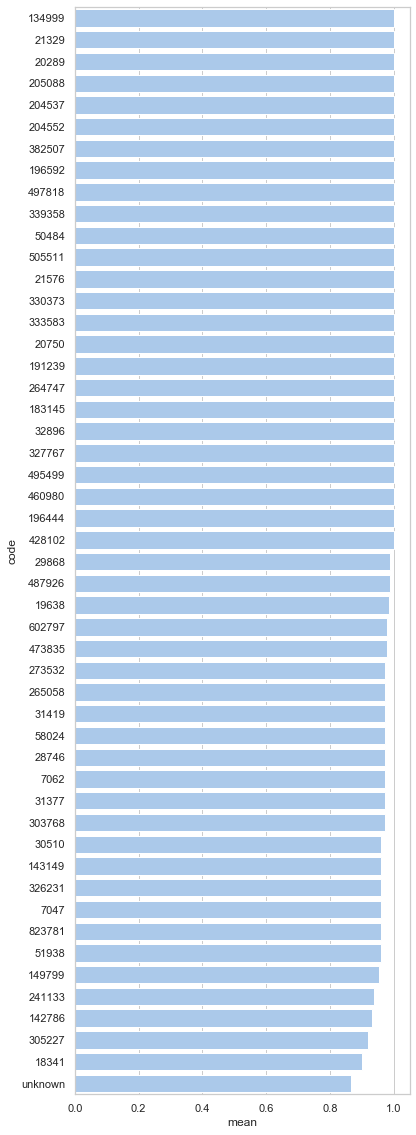

In [9]:
"""

Memo
---- 
1. performance plot

   perplot: https://pypi.org/project/perfplot/
"""
import seaborn as sns
import matplotlib.pyplot as plt
from analyzer import load_performance, label_by_performance
from utils_sys import size_hashtable

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 20))
sns.set_color_codes("pastel")

#---------------------------------------------

# load performance data
cohort = 'hepatitis-c'
df_perf = load_performance(input_dir='result', cohort=cohort)
print("> dim(performance matrix): {}".format(df_perf.shape))

# sort ~ performance scores 
# df_perf = df_perf.sort_values(by=['mean', ], ascending=False)

categories = ['easy', 'hard', 'low']
ccmap = label_by_performance(cohort=cohort, categories=categories)
N = size_hashtable(ccmap)
N_easy = len(ccmap['easy'])
N_hard = len(ccmap['hard'])
N_low = len(ccmap['low'])
print("[analysis] N(codes; cohort={}): {}".format(cohort, N))
print("...        n(easy): {} | ratio: {}".format(N_easy, N_easy/(N+0.0)))
print("...        n(hard): {} | ratio: {}".format(N_hard, N_hard/(N+0.0)))
print("...        n(low):  {} | ratio: {}".format(N_low,  N_low/(N+0.0)))

header = ['code', 'mean', 'std', 'n_pos']
codes = df_perf['code']
n_codes = len(codes)
scores = df_perf['mean']

# some statistics
score_high = 0.90
score_low = 0.50

codes_low_sz = ccmap['low']
codes_scored = np.hstack( [ccmap['easy'], ccmap['hard']] )
codes_high_score = ccmap['easy']
assert n_codes == len(codes_low_sz) + len(codes_scored)

print("1. Total number of codes: {} | n(low_sample): {}, n(scored):{}, n(high scored):{}".format(n_codes, 
   len(codes_low_sz), len(codes_scored), len(codes_high_score)))

r_scored = len(codes_scored)/(n_codes+0.0)
rh = len(codes_high_score)/(n_codes+0.0)
print("2. Fraction of scored codes: {}".format(r_scored))
print("3. Fraction of highly scored codes: {}".format(rh))

# Effective performance dataframe, ruling out those codes without scores (due to low sample sizes)
df_eff = df_perf.loc[df_perf['mean'] >= 0.0]

n_offset = 25
df_topn = df_eff.sort_values(['mean', ], ascending=False).head(n_offset)
df_botn = df_eff.sort_values(['mean', ], ascending=True).head(n_offset)
# print(df_botn)

# codes = [str(c) for c in df_botn['code'].values]
# print('lower codes: {}'.format(codes))
# scores = df_botn['mean'].values
# print('scores: {}'.format(scores))

# top n + bottom n
dfe = pd.concat([df_topn, df_botn], ignore_index=True)
dfe.sort_values(by=['mean', ], ascending=False, inplace=True)
codes = [str(c) for c in dfe['code'].values]
scores = dfe['mean'].values
# print('lower(n)+higher codes(n): {}'.format(codes))
# print('scores: {}'.format(scores))
print(dfe)

# sns.barplot(x="total", y="abbrev", data=crashes,
#             label="Total", color="b")

# --------------------
# ax = sns.barplot(x='mean', y='code', data=df_botn)
# print("-------------------------\n\n")
# print("> dtype: {}".format(df_botn.dtypes))
# print(df_botn.head(10))

# dfe = dfe[['mean', 'code']]
# dfe.plot(kind='bar')

sns.barplot(x='mean', y='code', data=dfe, order=dfe['code'], # order has to be specified; even if already sorted!!!
            label="LOINC", color="b", orient='h')

# ax = sns.barplot(x='mean', y='code', data=df)

# ax.set_xlabel('Fmax Score')
# ax.set_ylabel('LOINC')